
Evaluating for Balanced Dataset

KNN Evaluation:
KNN Best Parameters: {'n_neighbors': 14, 'weights': 'distance'}
KNN Confusion Matrix:
 [[3221 1546]
 [1198 3569]]
KNN Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.68      0.70      4767
           1       0.70      0.75      0.72      4767

    accuracy                           0.71      9534
   macro avg       0.71      0.71      0.71      9534
weighted avg       0.71      0.71      0.71      9534

KNN ROC AUC: 0.778668168671856
KNN Best Cross Validation Score: 0.7728272173685452


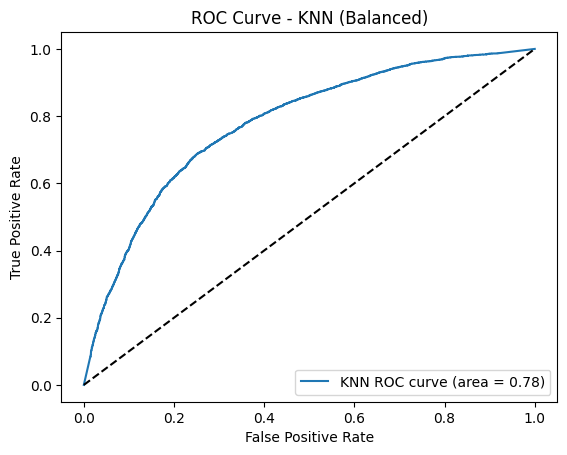

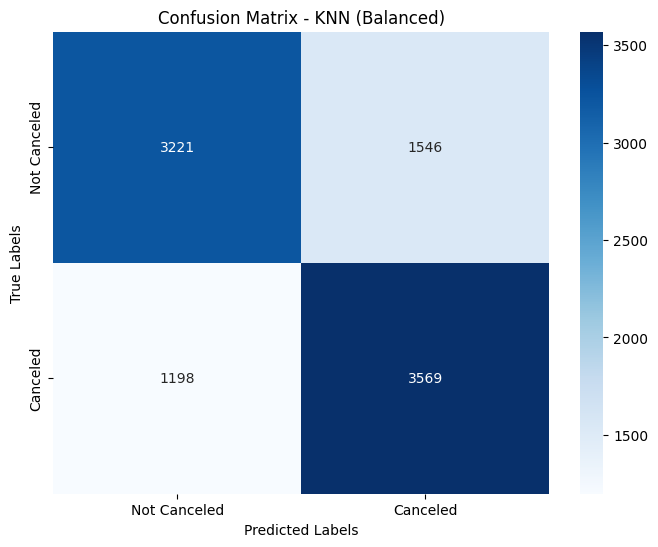

C:\Users\nikhi\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [04:41:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\nikhi\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [04:41:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\nikhi\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [04:41:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are


XGBoost Evaluation:
XGBoost Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.7}
XGBoost Confusion Matrix:
 [[3614 1153]
 [1112 3655]]
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.76      0.76      4767
           1       0.76      0.77      0.76      4767

    accuracy                           0.76      9534
   macro avg       0.76      0.76      0.76      9534
weighted avg       0.76      0.76      0.76      9534

XGBoost ROC AUC: 0.8481024862868096
XGBoost Best Cross Validation Score: 0.8494304060206813


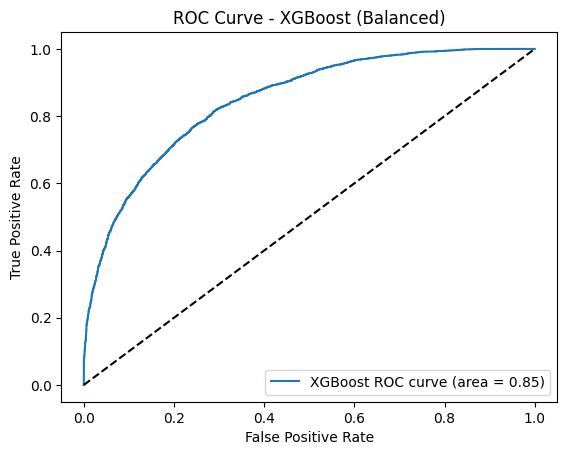

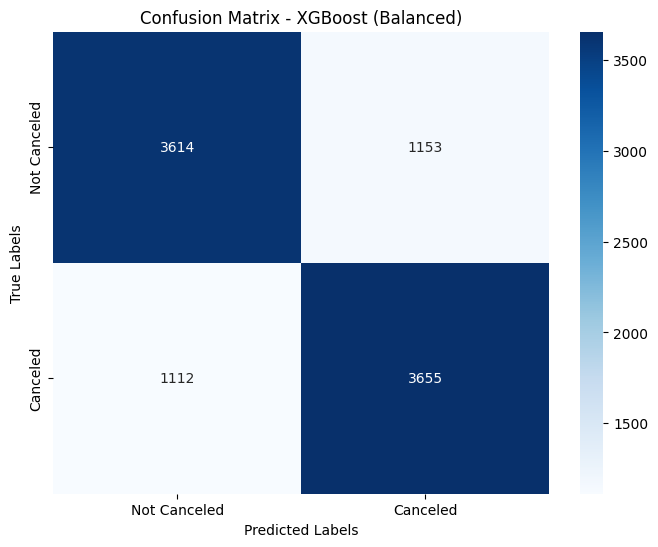

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample

def preprocess_data(data):
    """
    Preprocess the data: handle missing values, encode categorical variables.
    """
    # Handle missing values
    if data.isnull().sum().sum() > 0:
        print("Missing values detected. Filling with median.")
        data = data.fillna(data.median())
    
    # One-hot encoding for categorical variables
    data = pd.get_dummies(data, drop_first=True)
    return data

def evaluate_dataset(data, dataset_type):
    """
    Evaluate a dataset (balanced or imbalanced) using KNN and XGBoost.
    """
    print(f"\n{'='*40}\nEvaluating for {dataset_type} Dataset\n{'='*40}")

    # Preprocess data
    data = preprocess_data(data)

    # Split into Features and Target
    X = data.drop('is_canceled', axis=1)
    y = data['is_canceled']

    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

    # Model 1: KNN
    knn_params = {'n_neighbors': list(range(3, 15)), 'weights': ['uniform', 'distance']}
    knn = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, scoring='roc_auc')
    knn.fit(X_train, y_train)

    # Predictions
    knn_pred = knn.predict(X_test)
    knn_prob = knn.predict_proba(X_test)[:, 1]

    # Evaluation
    print("\nKNN Evaluation:")
    print("KNN Best Parameters:", knn.best_params_)
    print("KNN Confusion Matrix:\n", confusion_matrix(y_test, knn_pred))
    print("KNN Classification Report:\n", classification_report(y_test, knn_pred))
    knn_roc_auc = roc_auc_score(y_test, knn_prob)
    print("KNN ROC AUC:", knn_roc_auc)
    print("KNN Best Cross Validation Score:", knn.best_score_)

    # KNN ROC Curve
    fpr, tpr, _ = roc_curve(y_test, knn_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f'KNN ROC curve (area = {knn_roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - KNN ({dataset_type})')
    plt.legend(loc="lower right")
    plt.show()

    # Visualize KNN Confusion Matrix with Heatmap
    conf_matrix_knn = confusion_matrix(y_test, knn_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_knn, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Canceled', 'Canceled'], yticklabels=['Not Canceled', 'Canceled'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix - KNN ({dataset_type})')
    plt.show()

    # Model 2: XGBoost
    xgb_params = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.3],
        'subsample': [0.7, 1]
    }
    xgb = GridSearchCV(
        XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=123), 
        xgb_params, 
        cv=5, 
        scoring='roc_auc'
    )
    xgb.fit(X_train, y_train)

    # Predictions
    xgb_pred = xgb.predict(X_test)
    xgb_prob = xgb.predict_proba(X_test)[:, 1]

    # Evaluation
    print("\nXGBoost Evaluation:")
    print("XGBoost Best Parameters:", xgb.best_params_)
    print("XGBoost Confusion Matrix:\n", confusion_matrix(y_test, xgb_pred))
    print("XGBoost Classification Report:\n", classification_report(y_test, xgb_pred))
    xgb_roc_auc = roc_auc_score(y_test, xgb_prob)
    print("XGBoost ROC AUC:", xgb_roc_auc)
    print("XGBoost Best Cross Validation Score:", xgb.best_score_)

    # XGBoost ROC Curve
    fpr, tpr, _ = roc_curve(y_test, xgb_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f'XGBoost ROC curve (area = {xgb_roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - XGBoost ({dataset_type})')
    plt.legend(loc="lower right")
    plt.show()

    # Visualize XGBoost Confusion Matrix with Heatmap
    conf_matrix_xgb = confusion_matrix(y_test, xgb_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Canceled', 'Canceled'], yticklabels=['Not Canceled', 'Canceled'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix - XGBoost ({dataset_type})')
    plt.show()

# Load Dataset
balanced_data = pd.read_csv("C:/Users/nikhi/Downloads/Balanced_hotel_data.csv")

# Evaluate Balanced Dataset
evaluate_dataset(balanced_data, "Balanced")




In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns


def preprocess_data(data):
    """
    Preprocess the data: handle missing values, encode categorical variables.
    """
    if data.isnull().sum().sum() > 0:
        print("Missing values detected. Filling with median.")
        data = data.fillna(data.median())
    data = pd.get_dummies(data, drop_first=True)
    return data


def plot_roc_curve(y_test, y_prob, model_name, dataset_type):
    """
    Plot the ROC Curve for the model.
    """
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f'{model_name} ROC curve (area = {roc_auc_score(y_test, y_prob):.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name} ({dataset_type})')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()


def plot_confusion_matrix(conf_matrix, model_name, dataset_type):
    """
    Plot a heatmap for the confusion matrix.
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Canceled', 'Canceled'], yticklabels=['Not Canceled', 'Canceled'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix - {model_name} ({dataset_type})')
    plt.grid(False)
    plt.show()


def evaluate_model(model, X_train, X_test, y_train, y_test, model_name, dataset_type):
    """
    Evaluate a single model and display metrics including classification report,
    confusion matrix, ROC curve, and cross-validation best score.
    """
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    y_test_prob = model.predict_proba(X_test)[:, 1]

    # Testing Metrics
    print(f"\n{model_name} Evaluation (Test - {dataset_type} Dataset):")
    print(f"{model_name} Best Parameters:", model.best_params_)
    print(f"{model_name} Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
    print(f"{model_name} Classification Report:\n", classification_report(y_test, y_test_pred))
    roc_auc = roc_auc_score(y_test, y_test_prob)
    print(f"{model_name} ROC AUC:", roc_auc)
    print(f"{model_name} Best Cross Validation Score:", model.best_score_)

    # Plot ROC Curve
    plot_roc_curve(y_test, y_test_prob, model_name, dataset_type)

    # Plot Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_test_pred)
    plot_confusion_matrix(conf_matrix, model_name, dataset_type)


def evaluate_dataset(data, dataset_type):
    """
    Evaluate a dataset using KNN and XGBoost with SMOTE and hyperparameter tuning.
    """
    print(f"\n{'='*40}\nEvaluating for {dataset_type} Dataset\n{'='*40}")
    data = preprocess_data(data)
    X = data.drop('is_canceled', axis=1)
    y = data['is_canceled']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

    # Apply SMOTE for oversampling (for training data only)
    smote = SMOTE(random_state=123, sampling_strategy='auto')
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    # Model 1: KNN with Hyperparameter Tuning
    knn_params = {
        'n_neighbors': list(range(5, 20)),
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }
    knn_model = RandomizedSearchCV(KNeighborsClassifier(), knn_params, cv=5, scoring='roc_auc', n_iter=20, random_state=123)
    evaluate_model(knn_model, X_train_smote, X_test, y_train_smote, y_test, "KNN", dataset_type)

    # Model 2: XGBoost with Hyperparameter Tuning
    xgb_params = {
        'n_estimators': [100, 200, 300],
        'max_depth': [5, 7, 9],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'scale_pos_weight': [1, len(y[y == 0]) / len(y[y == 1])],  # Dynamic imbalance handling
        'gamma': [0, 0.1, 0.2, 0.3]
    }
    xgb_model = RandomizedSearchCV(
        XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=123),
        xgb_params, cv=5, scoring='roc_auc', n_iter=20, random_state=123
    )
    evaluate_model(xgb_model, X_train_smote, X_test, y_train_smote, y_test, "XGBoost", dataset_type)


# Load Dataset
balanced_data = pd.read_csv("C:/Users/nikhi/Downloads/Balanced_hotel_data.csv")

# Evaluate Balanced Dataset
evaluate_dataset(balanced_data, "Balanced")




In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# =======================================
# Load Dataset
# =======================================
file_path = "C:/Users/nikhi/Downloads/Balanced_hotel_data.csv"
data = pd.read_csv(file_path)

# Separate features and target
X = data.drop(columns=['is_canceled'])  # Assuming 'is_canceled' is the target
y = data['is_canceled']

# Imbalanced dataset creation
imbalance_data = pd.concat([data[data['is_canceled'] == 1].sample(frac=0.5), data[data['is_canceled'] == 0]])
X_imbalanced = imbalance_data.drop(columns=['is_canceled'])
y_imbalanced = imbalance_data['is_canceled']

# =======================================
# Split Data for Training and Testing
# =======================================
# Train-test split for both balanced and imbalanced datasets
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train_imb, X_test_imb, y_train_imb, y_test_imb = train_test_split(X_imbalanced, y_imbalanced, test_size=0.2, random_state=42, stratify=y_imbalanced)

# Scale the features
scaler = StandardScaler()
X_train_bal_scaled = scaler.fit_transform(X_train_bal)
X_test_bal_scaled = scaler.transform(X_test_bal)
X_train_imb_scaled = scaler.fit_transform(X_train_imb)
X_test_imb_scaled = scaler.transform(X_test_imb)


# Model Evaluation Function

def evaluate_model(model, X_test, y_test, dataset_type):
    print(f"\nModel Evaluation on {dataset_type} Dataset:")
    y_pred = model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred))


# KNN Model with Cross-Validation and Hyperparameter Tuning

def train_knn(X_train, y_train, X_test, y_test, dataset_type):
    print(f"\nTraining KNN Classifier ({dataset_type})...\n")
    knn = KNeighborsClassifier()
    knn_params = {
        'n_neighbors': list(range(1, 21)),
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    knn_grid = GridSearchCV(knn, param_grid=knn_params, cv=skf, scoring='accuracy', verbose=1)
    knn_grid.fit(X_train, y_train)

    print(f"Best Parameters for KNN ({dataset_type}):", knn_grid.best_params_)
    print(f"Best Cross-Validation Accuracy ({dataset_type}):", knn_grid.best_score_)

    evaluate_model(knn_grid.best_estimator_, X_test, y_test, dataset_type)
    return knn_grid.best_estimator_


# XGBoost Model with Cross-Validation and Hyperparameter Tuning

def train_xgboost(X_train, y_train, X_test, y_test, dataset_type):
    print(f"\nTraining XGBoost Classifier ({dataset_type})...\n")
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    xgb_params = {
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'n_estimators': [50, 100, 200],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0]
    }
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    xgb_grid = GridSearchCV(xgb, param_grid=xgb_params, cv=skf, scoring='accuracy', verbose=1)
    xgb_grid.fit(X_train, y_train)

    print(f"Best Parameters for XGBoost ({dataset_type}):", xgb_grid.best_params_)
    print(f"Best Cross-Validation Accuracy ({dataset_type}):", xgb_grid.best_score_)

    evaluate_model(xgb_grid.best_estimator_, X_test, y_test, dataset_type)
    return xgb_grid.best_estimator_


# Train and Evaluate Models on Balanced Data

best_knn_bal = train_knn(X_train_bal_scaled, y_train_bal, X_test_bal_scaled, y_test_bal, "Balanced")
best_xgb_bal = train_xgboost(X_train_bal, y_train_bal, X_test_bal, y_test_bal, "Balanced")


# Train and Evaluate Models on Imbalanced Data

best_knn_imb = train_knn(X_train_imb_scaled, y_train_imb, X_test_imb_scaled, y_test_imb, "Imbalanced")
best_xgb_imb = train_xgboost(X_train_imb, y_train_imb, X_test_imb, y_test_imb, "Imbalanced")


# Feature Importance Visualization (XGBoost)

def plot_feature_importance(model, X, dataset_type):
    importance = model.feature_importances_
    feature_names = X.columns
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance}).sort_values(by='Importance', ascending=False)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
    plt.title(f"Feature Importance ({dataset_type} - XGBoost)")
    plt.xlabel("Importance Score")
    plt.ylabel("Features")
    plt.tight_layout()
    plt.show()

plot_feature_importance(best_xgb_bal, X, "Balanced")
plot_feature_importance(best_xgb_imb, X_imbalanced, "Imbalanced")



Training KNN Classifier (Balanced)...

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Best Parameters for KNN (Balanced): {'metric': 'manhattan', 'n_neighbors': 18, 'weights': 'distance'}
Best Cross-Validation Accuracy (Balanced): 0.7276589688511044

Model Evaluation on Balanced Dataset:
Accuracy: 0.7304384308789595
Confusion Matrix:
[[3322 1445]
 [1125 3642]]
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.70      0.72      4767
           1       0.72      0.76      0.74      4767

    accuracy                           0.73      9534
   macro avg       0.73      0.73      0.73      9534
weighted avg       0.73      0.73      0.73      9534


Training XGBoost Classifier (Balanced)...

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


C:\Users\nikhi\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:54:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\nikhi\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:54:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\nikhi\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:54:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Fitting 5 folds for each of 80 candidates, totalling 400 fits

KNN Results:
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 18, 'weights': 'uniform'}
Best CV Accuracy: 0.8537658955920163
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     12434
           1       0.61      0.19      0.29      2384

    accuracy                           0.85     14818
   macro avg       0.73      0.58      0.60     14818
weighted avg       0.82      0.85      0.81     14818



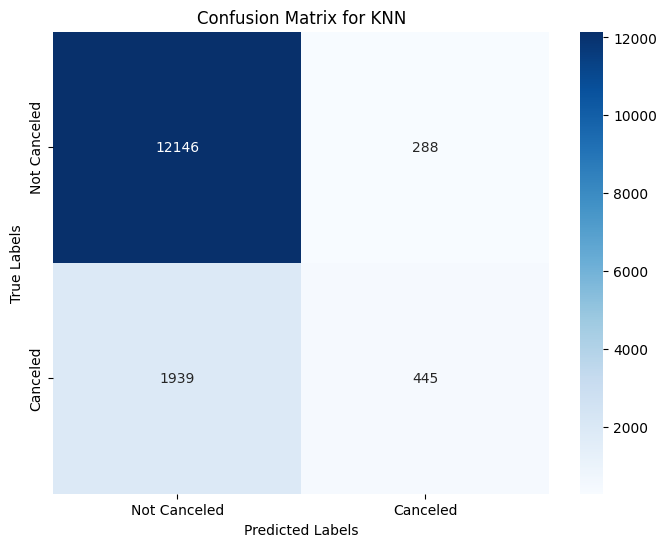

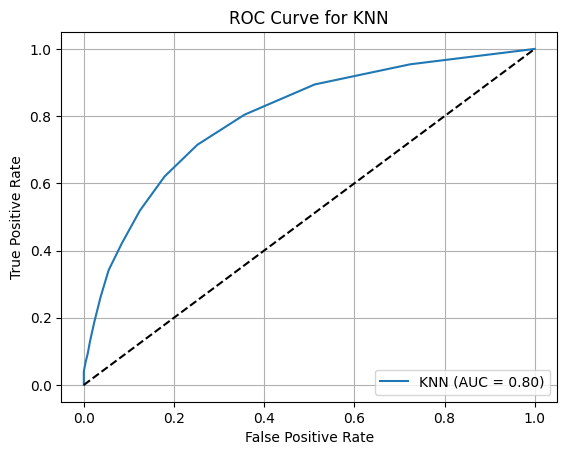

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


C:\Users\nikhi\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [03:51:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\nikhi\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [03:51:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\nikhi\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [03:51:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns


# Load Dataset

file_path = "C:/Users/nikhi/Downloads/Unbalanced_hotel_data.csv"
data = pd.read_csv(file_path)

# Separate features and target
X = data.drop(columns=['is_canceled'])  # Assuming 'is_canceled' is the target
y = data['is_canceled']

# Create an imbalanced dataset
imbalance_data = pd.concat([data[data['is_canceled'] == 1].sample(frac=0.5, random_state=42), 
                            data[data['is_canceled'] == 0]])
X_imbalanced = imbalance_data.drop(columns=['is_canceled'])
y_imbalanced = imbalance_data['is_canceled']


# Split Data for Training and Testing

X_train_imb, X_test_imb, y_train_imb, y_test_imb = train_test_split(
    X_imbalanced, y_imbalanced, test_size=0.2, random_state=42, stratify=y_imbalanced)

# Scale the features
scaler = StandardScaler()
X_train_imb_scaled = scaler.fit_transform(X_train_imb)
X_test_imb_scaled = scaler.transform(X_test_imb)


def plot_roc_curve(y_test, y_prob, model_name):
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = roc_auc_score(y_test, y_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'ROC Curve for {model_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Canceled', 'Canceled'], yticklabels=['Not Canceled', 'Canceled'])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()


# KNN Model with Cross-Validation and Hyperparameter Tuning

def train_knn(X_train, y_train, X_test, y_test):
    knn = KNeighborsClassifier()
    knn_params = {
        'n_neighbors': list(range(1, 21)),
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    knn_grid = GridSearchCV(knn, param_grid=knn_params, cv=skf, scoring='accuracy', verbose=1)
    knn_grid.fit(X_train, y_train)

    print("\nKNN Results:")
    print("Best Parameters:", knn_grid.best_params_)
    print("Best CV Accuracy:", knn_grid.best_score_)

    y_pred = knn_grid.predict(X_test)
    y_prob = knn_grid.predict_proba(X_test)[:, 1]
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, "KNN")
    plot_roc_curve(y_test, y_prob, "KNN")
    return knn_grid.best_estimator_

# XGBoost Model with Cross-Validation and Hyperparameter Tuning

def train_xgboost(X_train, y_train, X_test, y_test):
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    xgb_params = {
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'n_estimators': [50, 100, 200],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0]
    }
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    xgb_grid = GridSearchCV(xgb, param_grid=xgb_params, cv=skf, scoring='accuracy', verbose=1)
    xgb_grid.fit(X_train, y_train)

    print("\nXGBoost Results:")
    print("Best Parameters:", xgb_grid.best_params_)
    print("Best CV Accuracy:", xgb_grid.best_score_)

    y_pred = xgb_grid.predict(X_test)
    y_prob = xgb_grid.predict_proba(X_test)[:, 1]
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, "XGBoost")
    plot_roc_curve(y_test, y_prob, "XGBoost")
    return xgb_grid.best_estimator_

# Train and Evaluate Models

best_knn_imb = train_knn(X_train_imb_scaled, y_train_imb, X_test_imb_scaled, y_test_imb)
best_xgb_imb = train_xgboost(X_train_imb, y_train_imb, X_test_imb, y_test_imb)
